In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import pandas as pd

from ip3_ca_ode_cfg import *
import cfg

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
def classification_simulation_with_row(df_row, t_0=0, t_f=400, max_step=0.1, input_type='glut'):
    '''
    Run the ip3 simulation with parameters given from pandas dataframe row
    '''
    cfg.A = df_row['A']
    cfg.d_rise = df_row['d_rise']
    cfg.d_decay = df_row['d_decay']
    cfg.r_rise = df_row['r_rise']
    cfg.r_decay = df_row['r_decay']

    if(input_type == 'glut'):
        sol = run_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'Gstar'):
        sol = run_Gstar_controlled_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'ip3'):
        sol = run_ip3_controlled_experiment('curve', t_f=t_f, max_step=max_step)
    return sol



def classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_0=0, t_f=400, max_step=0.2,
                                       input_type='glut'):
    '''
    Run the full system simulation for values to shape glutamate transient
    
    A, d_rise, d_decay, r_rise, r_decay: input curve parameters
    input_type: 'glut'/'ip3' - what system to run control for
    '''
    cfg.A = A
    cfg.d_rise = d_rise
    cfg.d_decay = d_decay
    cfg.r_rise = r_rise
    cfg.r_decay = r_decay
    
    if(input_type == 'glut'):
        sol = run_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'ip3'):
        sol = run_ip3_controlled_experiment('curve', t_f=t_f, max_step=max_step)
    return sol
    
    
    

'''
------------------------
Classification Functions
------------------------
These functions will be used to tell use what type of calcium response we have
as well as the IP3 characteristics
'''

def ip3_characteristics(t_0, t_f):
    '''
    This function returns some characteristic information about the ip3 curve
    It uses the globally set ip3 curve parameters (d_rise, d_decay, r_rise, r_decay)
    which are set using set_ip3_curve_manual, then ip3_curve_input gives the actual ip3 curve
    
    returns: ip3_total, ip3_amplitude, t_peak, t_duration
    ip3_total: total amount of ip3 in the transient curve
    ip3_amplitude: the height of ip3 at peak
    t_peak: the time of peak
    t_duration: the total time the ip3 transient lasted
    '''
    #get the ip3 curve
    t = np.arange(t_0, t_f, 0.1)
    p = np.zeros(len(t))
    for i in range(len(t)):
        p[i] = ip3_curve_input(t[i])
    
    ip3_total = np.sum(p) / len(p) * t_f #mean instantaneous ip3 multiplied by total time
    
    peaks, _ = scipy.signal.find_peaks(p) #find the index of maximum value of ip3
    if(len(peaks) > 0):
        peak = peaks[0]
    else:
        peak = False
        
    ip3_amplitude = p[peak]
    t_peak = t[peak]
    
    t_start_index = np.argmax(p > 0) #find first occurence that ip3 > 0
    t_end_index = peak + np.argmax(p[peak:] < 0.005) #find first time after the peak that ip3 < 0.005
    t_duration = t[t_end_index] - t[t_start_index]
    
    if(peak == False):
        t_duration = t_f #if there are no peaks, the "duration" is the entire simulation
    
    return ip3_total, ip3_amplitude, t_peak, t_duration
    

def calcium_peaks_and_troughs(t, c, index=True):
    '''
    Determine where the peaks and troughs are in the calcium response
    Pass t and c given by the numerical ODE solver
    index: True/False, if True will return indices of peaks and troughs, rather than values
    
    returns: 
      (index == False): t_peaks, c_peaks, t_troughs, c_troughs
      (index == True): peaks, troughs
    '''
    base_c = c[0]
    response_start_index = np.argmax(c > 1.4 * base_c) #we label the first time the calcium is 1.4 times base level
                                                        #as the start of the calcium response
    peaks, _ = scipy.signal.find_peaks(c) #note that these functions find the indices of peaks and troughs
    peaks = peaks[t[peaks] > cfg.t_star] #real peaks are those that happend after the start of the ip3 signal
    troughs, _ = scipy.signal.find_peaks(-c)
    true_troughs = []
    
    #the only troughs that we should count are the ones that lie between two peaks
    t_first_peak = t[peaks[0]]
    t_last_peak = t[peaks[-1]]
    for trough in troughs:
        if(t_first_peak < t[trough] and t[trough] < t_last_peak):
            true_troughs.append(trough)
    
    if(index):
        return peaks, true_troughs
    else:
        #convert indices to values
        t_peaks = t[peaks]
        c_peaks = c[peaks]
        t_troughs = t[true_troughs]
        c_troughs = c[true_troughs]        
        return t_peaks, c_peaks, t_troughs, c_troughs
    

    
def calcium_response_characteristics(t, c, peaks):
    '''
    Get characteristics of the calcium curve
    '''
    #determine start of calcium response to be 1.4x the baseline value
    base_c = c[1]
    response_start_index = np.argmax(c > 1.4 * base_c)
    last_peak = peaks[-1]
    response_end_index = last_peak + np.argmax(c[last_peak:] < 1.4 * base_c) #find end of response
    
    t_response_start = t[response_start_index]
    t_response_end = t[response_end_index]
    t_duration = t_response_end - t_response_start
    
    base_c = c[response_start_index - 3] #our baseline for calcium is the value of c before response starts
    max_height_c = np.max(c) - base_c
    
    c_means = (c[response_start_index : response_end_index - 1] +\
               c[response_start_index + 1 : response_end_index]) / 2
    c_total = np.sum(np.diff(t[response_start_index : response_end_index]) * c_means)
    
    return response_start_index, response_end_index, t_duration, base_c, max_height_c, c_total
    
    


def visualize_classification(t, c, x_max=150, ret=False):
    '''
    Visualize what the algorithm is observing to classify a response
    '''
    plt.figure(figsize=(8,8))
    plt.plot(t, c)
    plt.plot(t[1:], np.diff(c) / np.diff(t))
    
    vis_dict, response = calcium_response_classification(t, c, vis=True)
    
    if(len(vis_dict['mp_peaks']) > 0):
        plt.scatter(t[vis_dict['mp_peaks']], c[vis_dict['mp_peaks']], c='blue')
    if(len(vis_dict['mp_troughs']) > 0):
        plt.scatter(t[vis_dict['mp_troughs']], c[vis_dict['mp_troughs']], c='red')
    if(vis_dict['end_first_response'] is not None):
        plt.scatter(t[vis_dict['end_first_response']], c[vis_dict['end_first_response']], c='green')
        plt.scatter(t[vis_dict['end_first_response']], [0], c='green')

#     print(t[vis_dict['end_first_response']])
    plt.scatter(t[vis_dict['response_start_index']], c[vis_dict['response_start_index']], c='black')
    plt.scatter(t[vis_dict['response_end_index']], c[vis_dict['response_end_index']], c='black')
    
    plt.plot([0, x_max], [0, 0], '--', c='green')
    plt.xlim([0, x_max])
    
    print(response)
    if(ret):
        return vis_dict

    

In [170]:

def calcium_response_classification(t, c, vis=False):
    '''
    Classify the type of calcium response given a specific ip3 transient curve
    vis: if this is set to True, at each classification we will instead return a dictionary
        holding the characteristics being used to identify the peak for visualization
        also we will print out information that helps to identify what the algorithm sees
    '''
    
    def conditional_vis_return(response, vis_dict, vis):
        '''
        simple helper function to return the appropriate thing
        '''
        if(vis):
            return vis_dict, response
        else:
            return response
    
    ll_duration = 70 #how long the calcium elevation has to be to be classified as long lasting
#     plt.plot(t, c)
    peaks, troughs = calcium_peaks_and_troughs(t, c)
    response_start_index, response_end_index, t_duration, base_c, max_height_c, c_total =\
                                calcium_response_characteristics(t, c, peaks)
    t_response_start = t[response_start_index]
    t_response_end = t[response_end_index]
    
    vis_dict = {
        'response_start_index': response_start_index,
        'response_end_index': response_end_index,
        'mp_peaks': [],
        'mp_troughs': [],
        'end_first_response': None,
        'base_c': base_c
    }
    
    if(len(peaks) == 0):
        #if there are no peaks, no response
        return conditional_vis_return('NR', vis_dict, vis)
    
    if(t_duration > 200):
        #calcium response duration too long
        return conditional_vis_return('O (too long)', vis_dict, vis)
    if(np.max(c[peaks]) < 0.4):
        #calcium peaks are too small
        return conditional_vis_return('O (too small)', vis_dict, vis)
    if(np.max(c[peaks]) > 3.5):
        #calcium peaks are too large
        return conditional_vis_return('O (too large)', vis_dict, vis)
 
    #real peaks are those that reach >5% of their adjacent peak
    mp_peaks = []
    for i, peak in enumerate(peaks):
        real_peak_index = 0
        if(i == 0):
            #the first peak is always real
            mp_peaks.append(peak)
        elif((c[peak] - base_c) > 0.05 * (c[mp_peaks[real_peak_index]] - base_c)):
#             if(vis):
#                 print('Previous peak {}, next peak {}'.format((c[peak] - base_c)))
            #otherwise, check is this peak is >5% of the adjacent (real) peak
            mp_peaks.append(peak)
            real_peak_index += 1
    vis_dict['mp_peaks'] = mp_peaks
    
    #real troughs are those that reach <50% of their surrounding max peaks
    mp_troughs = []
    for i, trough in enumerate(troughs):
        #get the peaks that are to the left and right of each trough
        left_peak = peaks[i]
        right_peak = peaks[i+1]
        if(left_peak in mp_peaks and right_peak in mp_peaks):
            max_peak = np.max([c[left_peak], c[right_peak]]) - base_c
            min_peak = np.min([c[left_peak], c[right_peak]]) - base_c
            if(c[trough] - base_c < 0.5 * min_peak):
                mp_troughs.append(trough)
    vis_dict['mp_troughs'] = mp_troughs

    last_peak = mp_peaks[-1]
    response_end_index = last_peak + np.argmax(c[last_peak:] < 1.4 * base_c) #find end of response
    t_response_end = t[response_end_index]
    
    #NOTE: UNSURE IF THIS IS IMPORTANT ATM
#     if(len(mp_troughs) >= len(mp_peaks)):
#         print('Warning: weird case reached')
#     if(len(peaks) > len(mp_peaks)):
#         print('Case: fewer mp_peaks')

    #make a list of times [response_start, mp_troughs, response_end]
    #so we can check if the distance between any of these start/end/trough points
    #is greater than the LL response limit
    response_checkpoints = np.append(t_response_start, t[mp_troughs])
    response_checkpoints = np.append(response_checkpoints, t_response_end)
    if( (np.diff(response_checkpoints) > ll_duration).any() ):
        if(vis):
            print('Some response segment was longer than 70s')
        #check if any of these time distances is greater than ll_duration
        return conditional_vis_return('LL', vis_dict, vis)

    elif(len(mp_troughs) > 0):
        if(vis):
            print('At least one valid trough <50% height of neighboring peaks')
        #otherwise, if we did indeed find any valid troughs and we know the
        #duration is short enough, we have found a MP
        return conditional_vis_return('MP', vis_dict, vis)

    else:
        if(vis):
            print('No valid troughs that were <50% height of neighboring peaks')
#         #now we are in the case that there are no valid troughs, i.e. only 1 valid peak
#         #first check if the whole response stays >15% max response for > ll_duration
#         c_levelled = c - base_c #c_levelled is the calcium response minus the base
#         response_15_index = c_levelled > max_height_c * 0.15
#         t_15 = t[response_15_index]
#         t_15_duration = t_15.max() - t_15.min() #this is the duration that response stays
#                                                 #above 15% of max
#         if(t_15_duration > ll_duration):
#             if(vis):
#                 print('No troughs and the entire reponse stayed about 15% max height ofr longer than 70s')
#             return conditional_vis_return('LL', vis_dict, vis)
        
        ll_c = c - base_c
        for i, peak in enumerate(mp_peaks):
            ll_c[peak:] = ll_c[peak:] - ((c[peak] - base_c) * 0.15)
            if i > 0:
                ll_c[peak:] = ll_c[peak:] + ((c[mp_peaks[i - 1]] - base_c) * 0.15)
        t_15 = t[ll_c > 0]
        t_15_duration = t_15.max() - t_15.min()
        if(t_15_duration > ll_duration):
            if(vis):
                print('No troughs and the entire reponse stayed about 15% max height ofr longer than 70s')
            return conditional_vis_return('LL', vis_dict, vis)
        
        #next we are trying to decide between SP and PL response
        #the major peak duration is the time between response start and the first time
        #the derivative is closest to zero after being negative (after the first peak)
        #or the first peak in c', whichever is sooner
        c_deriv = np.diff(c) / np.diff(t)
        c_neg_deriv = c_deriv[t[1:] > t[peaks[0]]] #this is the c_deriv array starting from after the first peak
        t_neg_deriv = t[t > t[peaks[0]]] #and the corresponding time array
        first_pos_deriv = np.argmax(c_neg_deriv >= 0) #this is the location of the first positive derivative

        t_first_pos = t_neg_deriv[first_pos_deriv] #this is the location in time for first positive derivative
        
        c_deriv_peaks = scipy.signal.find_peaks(c_neg_deriv)[0] #peaks in c derivative after first peak
        if(len(c_deriv_peaks) > 0):
            #if there is a valid peak in c', see if it comes before the first time that
            #c' crosses zero after being negative
            #whichever comes first is the end of the first peak
            t_deriv_peak = t_neg_deriv[c_deriv_peaks[0]]
            if(t_deriv_peak < t_first_pos):
                end_first_response = c_deriv_peaks[0]
            else:
                end_first_response = first_pos_deriv
        else:
            end_first_response = first_pos_deriv
        
        #correct the index to account for us starting the search after first peak
        end_first_response = end_first_response + peaks[0]
        
        vis_dict['end_first_response'] = end_first_response
        t_end_first_response = t[end_first_response]

        first_peak_dur = t_end_first_response - t_response_start
        remaining_dur = t_response_end - t_end_first_response
        
        if(vis):
            print('First response lasted for ' + str(first_peak_dur))
            print('Remaining durations is ' + str(remaining_dur))
        if(remaining_dur > first_peak_dur * 0.5):
            return conditional_vis_return('PL', vis_dict, vis)

        else:
            return conditional_vis_return('SP', vis_dict, vis)
        
    return conditional_vis_return('No Classification', vis_dict, vis)



def find_results_around(results, response_duration, c_total, r_dur_width=5, c_total_width=5):
    '''
    return a section of the results df around a portion of the graph
    '''
    res = results[results['response_duration'] >= response_duration - r_dur_width]
    res = res[res['response_duration'] <= response_duration + r_dur_width]
    res = res[res['c_total'] >= c_total - c_total_width]
    res = res[res['c_total'] <= c_total + c_total_width]
    return res

## Testing plot

This plot shows what the classification algorithm is looking at

SP


(0, 150)

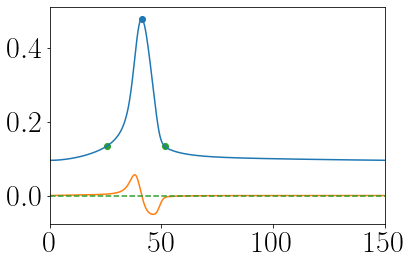

In [99]:
ll_duration=70
t = cfg.t
c = cfg.c
t_f_index = np.argmax(t > 250)
plt.plot(t[:t_f_index], c[:t_f_index])
peaks, troughs = calcium_peaks_and_troughs(t, c)
response_start_index, response_end_index, t_duration, base_c, max_height_c, c_total  =\
                            calcium_response_characteristics(t, c, peaks)
t_response_start = t[response_start_index]
t_response_end = t[response_end_index]

#real peaks are those that reach >5% of their adjacent peak
mp_peaks = []
for i, peak in enumerate(peaks):
    real_peak_index = 0
    if(i == 0):
        #the first peak is always real
        mp_peaks.append(peak)
    elif(c[peak] > 0.05 * c[mp_peaks[real_peak_index]]):
        #otherwise, check is this peak is >5% of the adjacent (real) peak
        mp_peaks.append(peak)
        real_peak_index += 1
    
#real troughs are those that reach <50% of their surrounding max peaks
mp_troughs = []
for i, trough in enumerate(troughs):
    #get the peaks that are to the left and right of each trough
    left_peak = peaks[i] 
    right_peak = peaks[i+1]
    max_peak = np.max([c[left_peak], c[right_peak]]) - base_c
    if(c[trough] - base_c < 0.5 * max_peak):
        mp_troughs.append(trough)
    
if(len(mp_troughs) >= len(mp_peaks)):
    print('Warning: weird case reached')
if(len(peaks) > len(mp_peaks)):
    print('Case: fewer mp_peaks')
    
#make a list of times [response_start, mp_troughs, response_end]
#so we can check if the distance between any of these start/end/trough points
#is greater than the LL response limit
response_checkpoints = np.append(t_response_start, t[mp_troughs])
response_checkpoints = np.append(response_checkpoints, t_response_end)
if( (np.diff(response_checkpoints) > ll_duration).any() ):
    #check if any of these time distances is greater than ll_duration
    print('LL')
        
elif(len(mp_troughs) > 0):
    #otherwise, if we did indeed find any valid troughs and we know the
    #duration is short enough, we have found a MP
    print('MP')

else:
    #now we are in the case that there are no valid troughs, i.e. only 1 valid peak
    #first check if the whole response stays >15% max response for > ll_duration
    c_levelled = c - base_c #c_levelled is the calcium response minus the base
    response_15_index = c_levelled > max_height_c * 0.15
    t_15 = t[response_15_index]
    t_15_duration = t_15.max() - t_15.min() #this is the duration that response stays
                                            #above 15% of max
    if(t_15_duration > ll_duration):
        print('LL')
    
    #next we are trying to decide between SP and PL response
    #the major peak duration is the time between response start and the first time
    #the derivative is closest to zero after being negative (after the first peak)
    c_deriv = np.diff(c) / np.diff(t)
    c_neg_deriv = c_deriv[t[1:] > t[peaks[0]] + 5] #this is the c_deriv array starting from after the first peak
    t_neg_deriv = t[t > t[peaks[0]] + 5] #and the corresponding time array
    first_pos_deriv = np.argmax(c_neg_deriv >= 0) #this is the location of the first positive derivative

    c_deriv_lim = c_neg_deriv[:first_pos_deriv] #this is the array that we want to search for when derivative
                                                #comes close to zero
    
    #now we want to look between the first peak and the first positive derivative of c
    #for the point where the derivative comes closest to zero
    #this point marks the end of the first peak response
    end_first_response = np.argmax(c_deriv_lim)
    t_end_first_response = t_neg_deriv[end_first_response]
    
    first_peak_dur = t_end_first_response - t_response_start
    remaining_dur = t_response_end - t_end_first_response
    
    if(remaining_dur > first_peak_dur * 0.5):
        print('PL')
    else:
        print('SP')
    
    
    
    





plt.scatter(t[peaks], c[peaks])
plt.scatter(t[mp_troughs], c[mp_troughs])
#plt.scatter(t[troughs], c[troughs])
plt.scatter(t[[response_start_index, response_end_index]], c[[response_start_index, response_end_index]], marker='o')
plt.plot(t[1:], np.diff(c) / np.diff(t))
plt.plot([0, 200], [0, 0], '--')
plt.xlim([0, 150])

___

# Plots

<Figure size 720x1440 with 0 Axes>

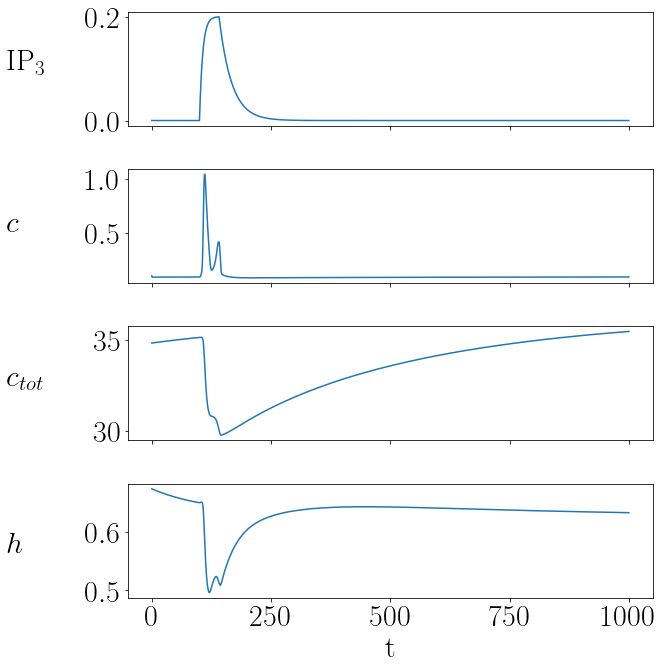

In [254]:
'''
Plot solutions Ca2+
'''
plt.figure(figsize=(10,20))

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10,10))

if(full_system):
    t_ca = t

#plot the ip3 input curve if we had set one
if('ip3_input_type' in sol.keys() and sol['ip3_input_type'] != None):
    t_ip3, p = get_input_plot(sol['ip3_input_type'])
else:
    t_ip3 = t_ca

#plot figures
ax[0].plot(t_ip3, p)
ax[1].plot(t_ca, c)
ax[2].plot(t_ca, c_tot)
ax[3].plot(t_ca, h)

#set xlabel
ax[3].set_xlabel('t')

#set ylabels
ax[0].set_ylabel(r'IP$_3$', rotation='horizontal', ha='left')
ax[1].set_ylabel(r'$c$', rotation='horizontal', ha='left')
ax[2].set_ylabel(r'$c_{tot}$', rotation='horizontal', ha='left')
ax[3].set_ylabel(r'$h$', rotation='horizontal', ha='left')

#align ylabels
ax[0].get_yaxis().set_label_coords(-0.23,0.4)
ax[1].get_yaxis().set_label_coords(-0.23,0.4)
ax[2].get_yaxis().set_label_coords(-0.23,0.4)
ax[3].get_yaxis().set_label_coords(-0.23,0.35)

fig.tight_layout()

# IP3 Range

This section is for recreating Fig 4 in Taheri et al. of the range of IP3 input parameters

In [187]:
%%time

A_range = [0.2, 0.375, 0.55, 0.725, 0.9]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
#r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, input_type='ip3')
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)



Trials completed: 50
Trials completed: 100
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Trials completed: 150
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Trials completed: 200
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Trials completed: 250
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Trials completed: 300
Case: fewer mp_peaks
Case: fewer mp_peaks
Trials completed: 350
Case: fewer mp_peaks
Case: fewer mp_peaks
Case: fewer mp_peaks
Trials completed: 400
Case: fewer mp_peaks
Case: fewer mp_peaks
Trials completed: 450
Case: fewer mp_peaks
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 8min 17s


## Plot for range of IP3 parameters

In [3]:
results = pd.read_pickle('data/ip3_classification')

In [4]:
maxes = []
best = 0
best_i = 0
for i in results.index:
    b = results.loc[i, 'c'].max()
    maxes.append(results.loc[i, 'c'].max())
    if b > best:
        best = b
        best_i = i

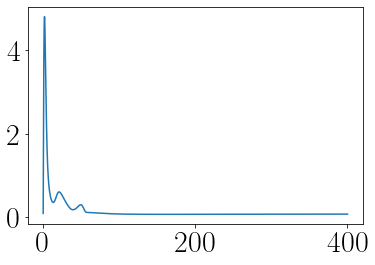

In [12]:
plt.plot(results.loc[best_i, 't'], results.loc[best_i, 'c'])

In [6]:
sol = classification_simulation_with_row(results.loc[best_i], input_type='ip3')

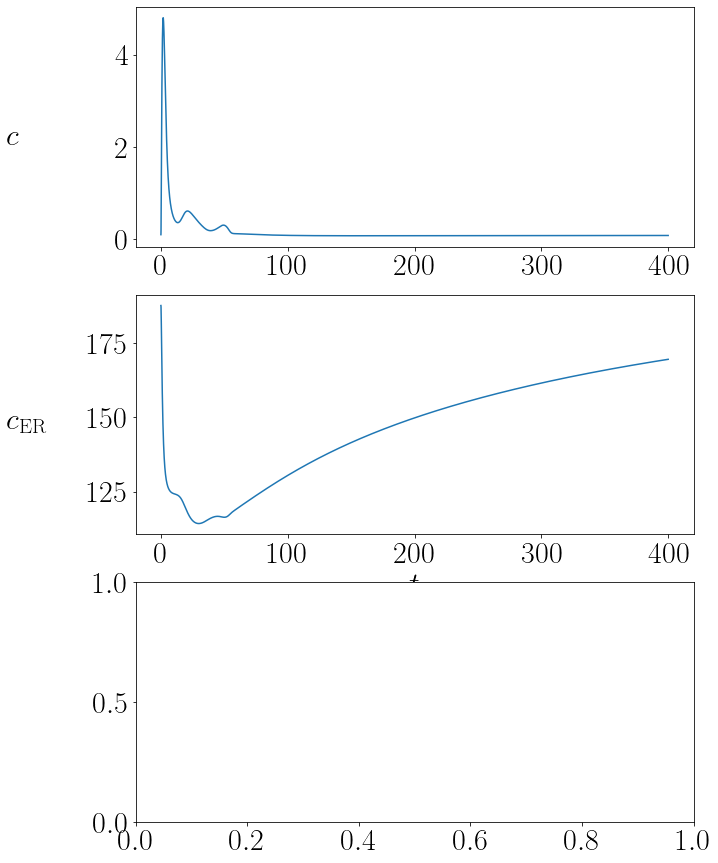

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
plot_experiment_plots(['c', 'c_er'], ax, plot_input=False)


(array([ 61.,  86., 111.,  66.,  55.,  65.,  61.,  35.,  37.,  23.]),
 array([0.79249696, 1.19331787, 1.59413878, 1.99495969, 2.3957806 ,
        2.79660151, 3.19742242, 3.59824333, 3.99906424, 4.39988515,
        4.80070606]),
 <a list of 10 Patch objects>)

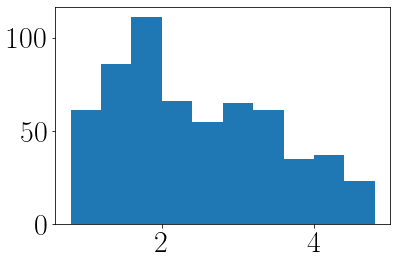

In [188]:
results.to_pickle('data/ip3_classification')

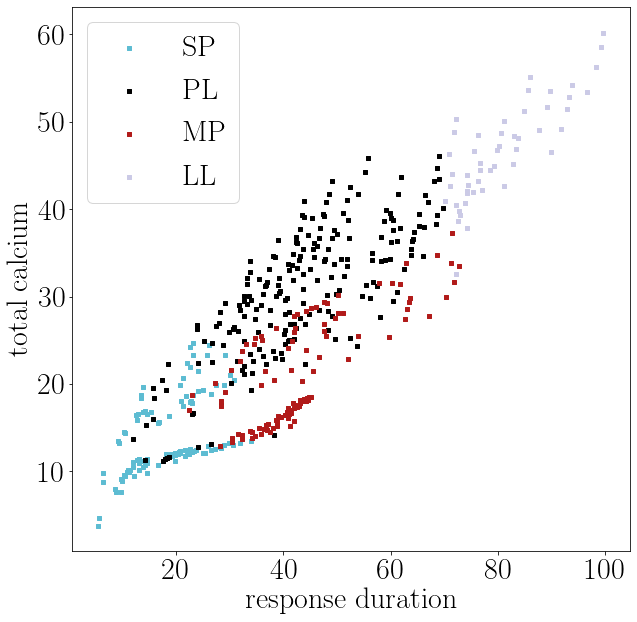

In [18]:
results = pd.read_pickle('data/ip3_classification')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
plt.savefig('figures/ca_classification/ip3_classification.png')

## Drill down on specific cases

Here, the following code helps us find a specific response near certain values of response_duration and c_total so we can examine what happened differently between our code and Greg's

In [5]:
results = pd.read_pickle('data/ip3_classification')

In [4]:
def find_results_around(results, response_duration, c_total, r_dur_width=5, c_total_width=5):
    '''
    return a section of the results df around a portion of the graph
    '''
    res = results[results['response_duration'] >= response_duration - r_dur_width]
    res = res[res['response_duration'] <= response_duration + r_dur_width]
    res = res[res['c_total'] >= c_total - c_total_width]
    res = res[res['c_total'] <= c_total + c_total_width]
    return res

In [174]:
res = find_results_around(results, 60, 35)
counter = 0

In [122]:
res

,A,d_decay,d_rise,r_decay,r_rise,response_type,response_duration,c_total,t,c
293,0.550,220,21,0.021366,1.000,O (too large),61.2,35.643706,"[0.0, 0.08838922367843528, 0.2883892236784353,...","[0.0951442, 0.0919830345715075, 0.110445261345..."
305,0.550,220,31,0.021366,0.070,PL,64.0,36.327917,"[0.0, 0.09515744354867287, 0.2951574435486729,...","[0.0951442, 0.09089087693707865, 0.08632691755..."
310,0.550,179,31,0.026260,0.150,PL,63.8,35.439220,"[0.0, 0.09512056666500171, 0.29512056666500175...","[0.0951442, 0.09089880985559817, 0.08666732300..."
311,0.550,220,31,0.021366,0.150,PL,66.2,37.945189,"[0.0, 0.09512056666500171, 0.29512056666500175...","[0.0951442, 0.09089880985559817, 0.08666732300..."
316,0.550,179,31,0.026260,0.300,PL,64.2,36.582950,"[0.0, 0.09485317878997163, 0.29485317878997164...","[0.0951442, 0.09095241810291761, 0.08843971975..."
317,0.550,220,31,0.021366,0.300,PL,68.6,39.276470,"[0.0, 0.09485317878997163, 0.29485317878997164...","[0.0951442, 0.09095241810291761, 0.08843971975..."
322,0.550,179,31,0.026260,0.800,PL,64.4,37.403474,"[0.0, 0.09102176336554008, 0.2910217633655401,...","[0.0951442, 0.091592698227389, 0.1026109439005..."
339,0.550,138,41,0.034061,0.090,PL,60.0,36.281801,"[0.0, 0.09515372914573661, 0.2951537291457366,...","[0.0951442, 0.09089169386621483, 0.08636536634..."
345,0.550,138,41,0.034061,0.150,PL,60.4,37.617655,"[0.0, 0.09512150352761116, 0.2951215035276112,...","[0.0951442, 0.09089861133633992, 0.08665931403..."
351,0.550,138,41,0.034061,0.300,PL,60.4,38.803843,"[0.0, 0.09485325558244519, 0.2948532555824452,...","[0.0951442, 0.09095240315597465, 0.08843926913..."


In [113]:
counter = 30

In [ ]:
# sol = classification_simulation_with_row(res.loc[31, :], input_type='ip3')
row = res.iloc[counter, :]
t = row['t']
c = row['c']
# visualize_classification(cfg.t, cfg.c, ret=True)
vis_dict = visualize_classification(t, c, ret=True)
counter += 1

In [148]:
c - vis_dict['base_c']

array([-0.0127739 , -0.01702723, -0.02159119, ..., -0.03043267,
       -0.03042869, -0.0304266 ])

In [166]:
ll_c = c - vis_dict['base_c']
mp_peaks = vis_dict['mp_peaks']
base_c = vis_dict['base_c']
for i, peak in enumerate(mp_peaks):
    ll_c[peak:] = ll_c[peak:] - ((c[peak] - base_c) * 0.15)
    if i > 0:
        ll_c[peak:] = ll_c[peak:] + ((c[mp_peaks[i - 1]] - base_c) * 0.15)
#     print(c[peak])

In [169]:
t[ll_c > 0]

array([ 2.29515744,  2.49515744,  2.69515744,  2.89515744,  3.09515744,
        3.29515744,  3.49515744,  3.69515744,  3.89515744,  4.09515744,
        4.29515744,  4.49515744,  4.69515744,  4.89515744,  5.09515744,
        5.29515744,  5.49515744,  5.69515744,  5.89515744,  6.09515744,
        6.29515744,  6.49515744,  6.69515744,  6.89515744,  7.09515744,
        7.29515744,  7.49515744,  7.69515744,  7.89515744,  8.09515744,
        8.29515744,  8.49515744,  8.69515744,  8.89515744,  9.09515744,
        9.29515744,  9.49515744,  9.69515744,  9.89515744, 10.09515744,
       10.29515744, 10.49515744, 10.69515744, 10.89515744, 11.09515744,
       11.29515744, 11.49515744, 11.69515744, 11.89515744, 12.09515744,
       12.29515744, 12.49515744, 12.69515744, 12.89515744, 13.09515744,
       13.29515744, 13.49515744, 13.69515744, 13.89515744, 14.09515744,
       14.29515744, 14.49515744, 14.69515744, 14.89515744, 15.09515744,
       15.29515744, 15.49515744, 15.69515744, 15.89515744, 16.09

In [78]:
vis_dict

{'response_start_index': 16,
 'response_end_index': 233,
 'mp_peaks': [39],
 'mp_troughs': [113],
 'end_first_response': None,
 'base_c': 0.10983760188909764}

In [71]:
(c[181] - vis_dict['base_c']) / (c[39] - vis_dict['base_c'])

0.01876889403397026

In [73]:
c[181] - vis_dict['base_c'] > 0.05 * (c[39] - vis_dict['base_c'])

False

No valid troughs that were <50% height of neighboring peaks
First response lasted for 11.199999999999962
Remaining durations is 5.399999999999981
SP


{'response_start_index': 48,
 'response_end_index': 131,
 'mp_peaks': [86],
 'mp_troughs': [],
 'end_first_response': 104}

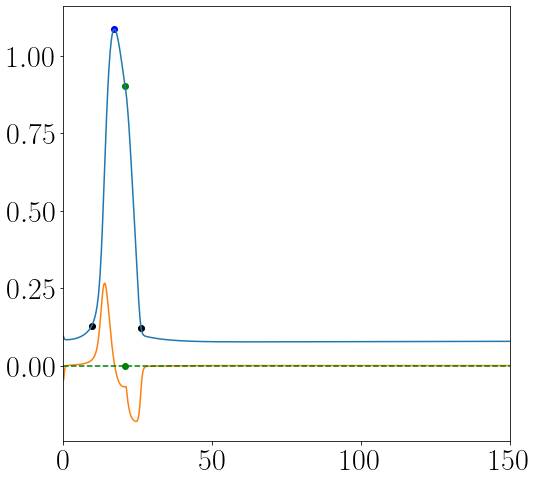

In [16]:
# sol = classification_simulation_with_row(res.loc[31, :], input_type='ip3')
row = res.loc[31, :]
t = row['t']
c = row['c']
# visualize_classification(cfg.t, cfg.c, ret=True)
visualize_classification(t, c, ret=True)

In [17]:
for i in 

,A,d_decay,d_rise,r_decay,r_rise,response_type,response_duration,c_total,t,c
0,0.2,15,1,0.245925,0.002,SP,5.4,3.749632,"[0.0, 0.09461978238179451, 0.29461978238179454...","[0.0951442, 0.09099850763573976, 0.08996877548..."
1,0.2,56,1,0.065873,0.002,SP,8.8,7.677894,"[0.0, 0.09461978238179451, 0.29461978238179454...","[0.0951442, 0.09099850763573976, 0.08996877548..."
2,0.2,97,1,0.038030,0.002,SP,10.0,8.895735,"[0.0, 0.09461978238179451, 0.29461978238179454...","[0.0951442, 0.09099850763573976, 0.08996877548..."
3,0.2,138,1,0.026731,0.002,SP,10.6,9.492625,"[0.0, 0.09461978238179451, 0.29461978238179454...","[0.0951442, 0.09099850763573976, 0.08996877548..."
4,0.2,179,1,0.020608,0.002,SP,11.2,9.881753,"[0.0, 0.09461978238179451, 0.29461978238179454...","[0.0951442, 0.09099850763573976, 0.08996877548..."
...,...,...,...,...,...,...,...,...,...,...
595,0.9,56,41,0.092731,0.800,O (too large),49.6,45.862083,"[0.0, 0.08368829900610347, 0.2836882990061035,...","[0.0951442, 0.09266177659649476, 0.12773020833..."
596,0.9,97,41,0.053536,0.800,O (too large),56.2,48.352121,"[0.0, 0.08368829900610347, 0.2836882990061035,...","[0.0951442, 0.09266177659649476, 0.12773020833..."
597,0.9,138,41,0.037630,0.800,O (too large),72.2,52.818416,"[0.0, 0.08368829900610347, 0.2836882990061035,...","[0.0951442, 0.09266177659649476, 0.12773020833..."
598,0.9,179,41,0.029011,0.800,O (too large),85.8,57.571013,"[0.0, 0.08368829900610347, 0.2836882990061035,...","[0.0951442, 0.09266177659649476, 0.12773020833..."


In [13]:
t[48]

9.495163746501062

---

# Classification for full system

Here are some examples of calcium traces generated from the full system

## Testing specific examples

No valid troughs that were <50% height of neighboring peaks
First response lasted for 90.40000000000103
Remaining durations is -53.00000000000104
SP


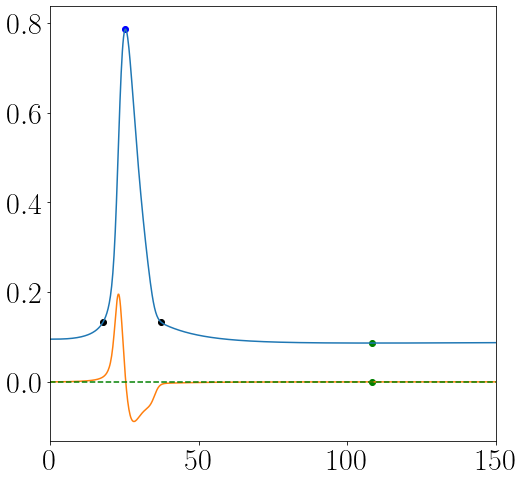

In [191]:
t_f = 200
#SP
A = 0.2
d_rise = 20
r_rise = 0.002
d_decay = 10
r_decay = compute_r_decay(A, d_decay)

sol = glutamate_classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=t_f)

visualize_classification(cfg.t, cfg.c)
plt.savefig('figures/ca_classification/SP_example.png')

No valid troughs that were <50% height of neighboring peaks
First response lasted for 21.00000000000005
Remaining durations is 38.77285415682441
PL


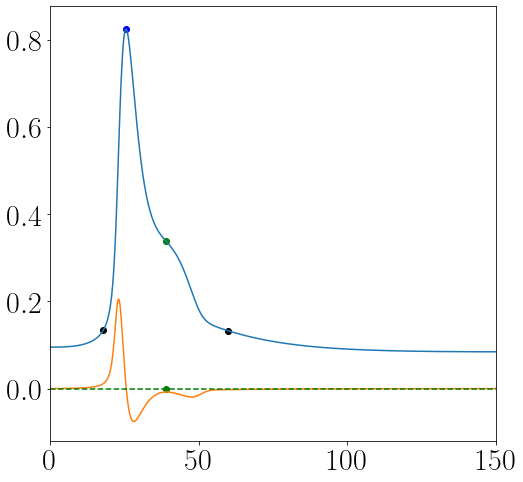

In [192]:
t_f = 200
#PL
A = 0.2
d_rise = 20
r_rise = 0.002
d_decay = 80
r_decay = compute_r_decay(A, d_decay)

sol = glutamate_classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=t_f)

vis_dict = visualize_classification(cfg.t, cfg.c, ret=True)
plt.savefig('figures/ca_classification/PL_example.png')

No valid troughs that were <50% height of neighboring peaks
First response lasted for 22.40000000000008
Remaining durations is 44.3876339914968
PL


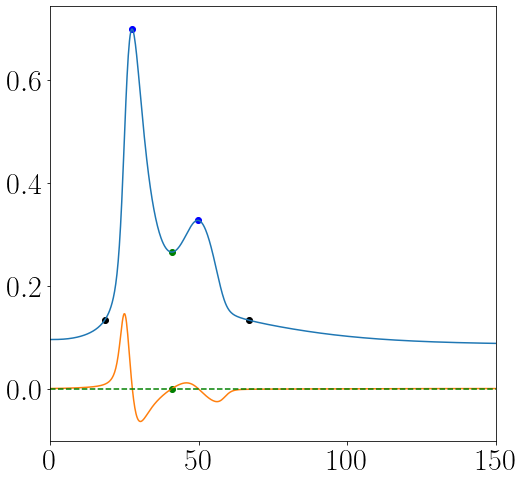

In [193]:
t_f = 200
#MP
A = 0.1
d_rise = 40
r_rise = 0.2
d_decay = 100
r_decay = compute_r_decay(A, d_decay)


sol = glutamate_classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=t_f)

visualize_classification(cfg.t, cfg.c)
plt.savefig('figures/ca_classification/MP_example.png')

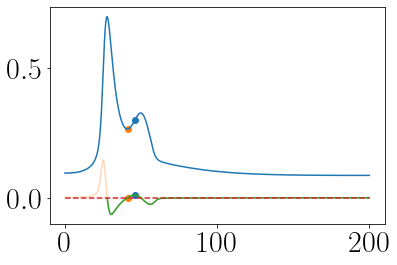

In [149]:
c = cfg.c
t = cfg.t
c_deriv = np.diff(c) / np.diff(t)
peaks = scipy.signal.find_peaks(c)[0]

c_neg_deriv = c_deriv[t[1:] > t[peaks[0]]]
t_neg_deriv = t[t > t[peaks[0]]]
c_neg = c[t > t[peaks[0]]]

first_pos_deriv = np.argmax(c_neg_deriv >= 0)
t_first_pos = t_neg_deriv[first_pos_deriv]

c_deriv_peaks = scipy.signal.find_peaks(c_neg_deriv)[0] #peaks in c derivative after first peak
if(len(c_deriv_peaks) > 0):
    t_deriv_peak = t_neg_deriv[c_deriv_peaks[0]]
    plt.scatter([t_deriv_peak, t_deriv_peak], [c_neg_deriv[c_deriv_peaks[0]], c_neg[c_deriv_peaks[0]]])
    


plt.scatter([t_first_pos, t_first_pos], [c_neg_deriv[first_pos_deriv], c_neg[first_pos_deriv]])

plt.plot(t, c)
plt.plot(t[1:], c_deriv, alpha=0.3)
plt.plot(t_neg_deriv, c_neg_deriv)
plt.plot([0, 200], [0, 0], '--')

## Running range of input parameters

In [179]:
%%time

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
#r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)



Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 4min 45s


## Plot for range of IP3 parameters

In [180]:
results.to_pickle('data/glut_classification')

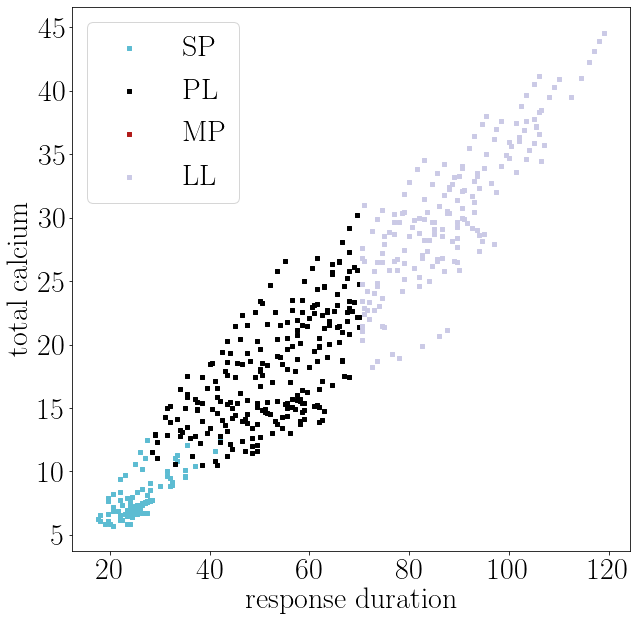

In [185]:
results = pd.read_pickle('data/glut_classification')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
plt.savefig('figures/ca_classification/glut_classification.png')

# Running Calcium Classification for full system with new GPCR model

In [4]:
%%time

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)



Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 6min 57s


## Plot for range of IP3 parameters

In [5]:
results = pd.read_pickle('data/glut_classification_new')

In [7]:
max_c = []
for i in results.index:
    max_c.append(results.loc[i, 'c'].max())
plt.hist(max_c)

(array([ 25.,   2.,   6.,  38.,  63.,  72.,  64., 121., 108., 101.]),
 array([0.10205554, 0.19709305, 0.29213057, 0.38716809, 0.4822056 ,
        0.57724312, 0.67228064, 0.76731815, 0.86235567, 0.95739319,
        1.0524307 ]),
 <a list of 10 Patch objects>)

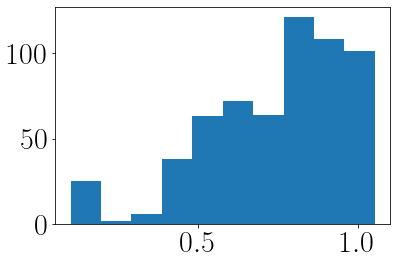

In [8]:
plt.hist(max_c)

In [4]:
results.to_pickle('data/glut_classification_new')

NameError: name 'results' is not defined

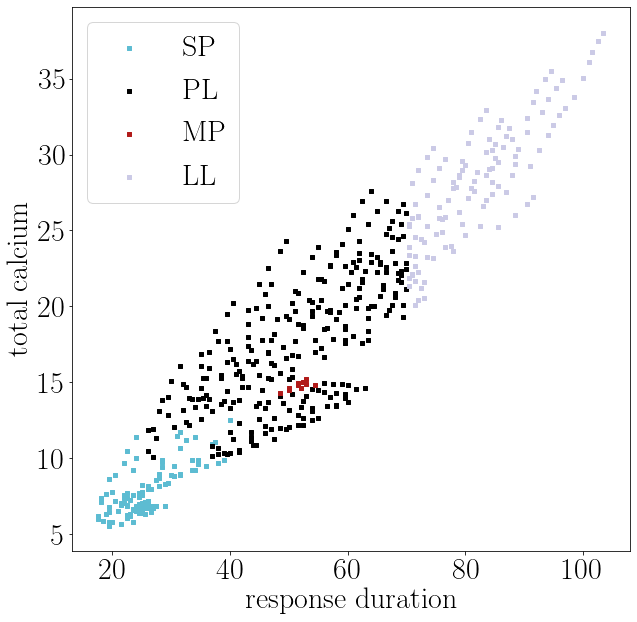

In [6]:
results = pd.read_pickle('data/glut_classification_new')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
plt.savefig('figures/ca_classification/glut_classification_new.png')

In [16]:
res = find_results_around(results, 45, 15)
indices = list(res.index)
T = len(indices)
i = 0

No valid troughs that were <50% height of neighboring peaks
First response lasted for 24.300000000000338
Remaining durations is 32.900000000000205
PL
Trial 23 out of 54


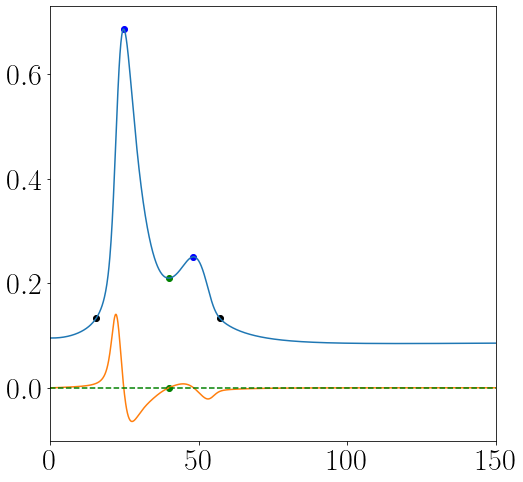

In [39]:
#go through each of the entries in the res dic
classification_simulation_with_row(results.loc[indices[i], :], input_type='glut')
visualize_classification(cfg.t, cfg.c)

i += 1
print(f'Trial {i} out of {T}')

## Doubling the amplitude of glutamate to increase total calcium to be more comparable with original plots

In [4]:
%%time

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# A_range = [0.1, 0.2, 0.6, 0.8]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)



Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Wall time: 3min 9s


## Plot for range of IP3 parameters

In [5]:
results.to_pickle('data/glut_classification_new2')

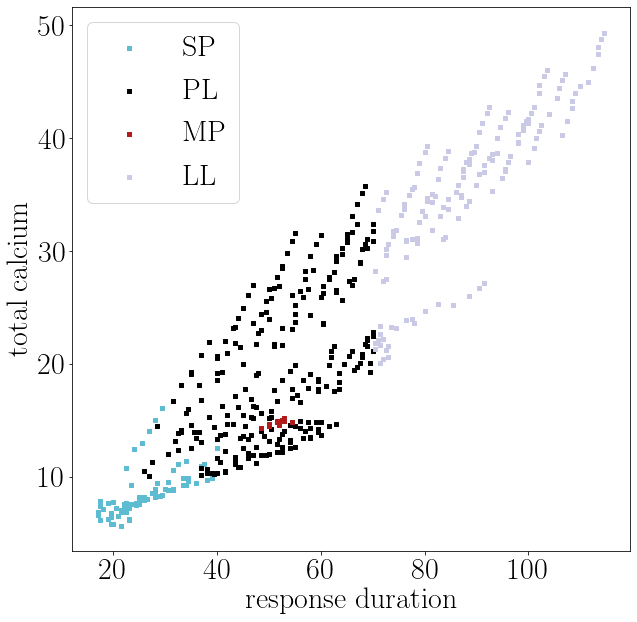

In [6]:
results = pd.read_pickle('data/glut_classification_new2')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
plt.savefig('figures/ca_classification/glut_classification_new2.png')

## Changing the G* -> IP3 strength


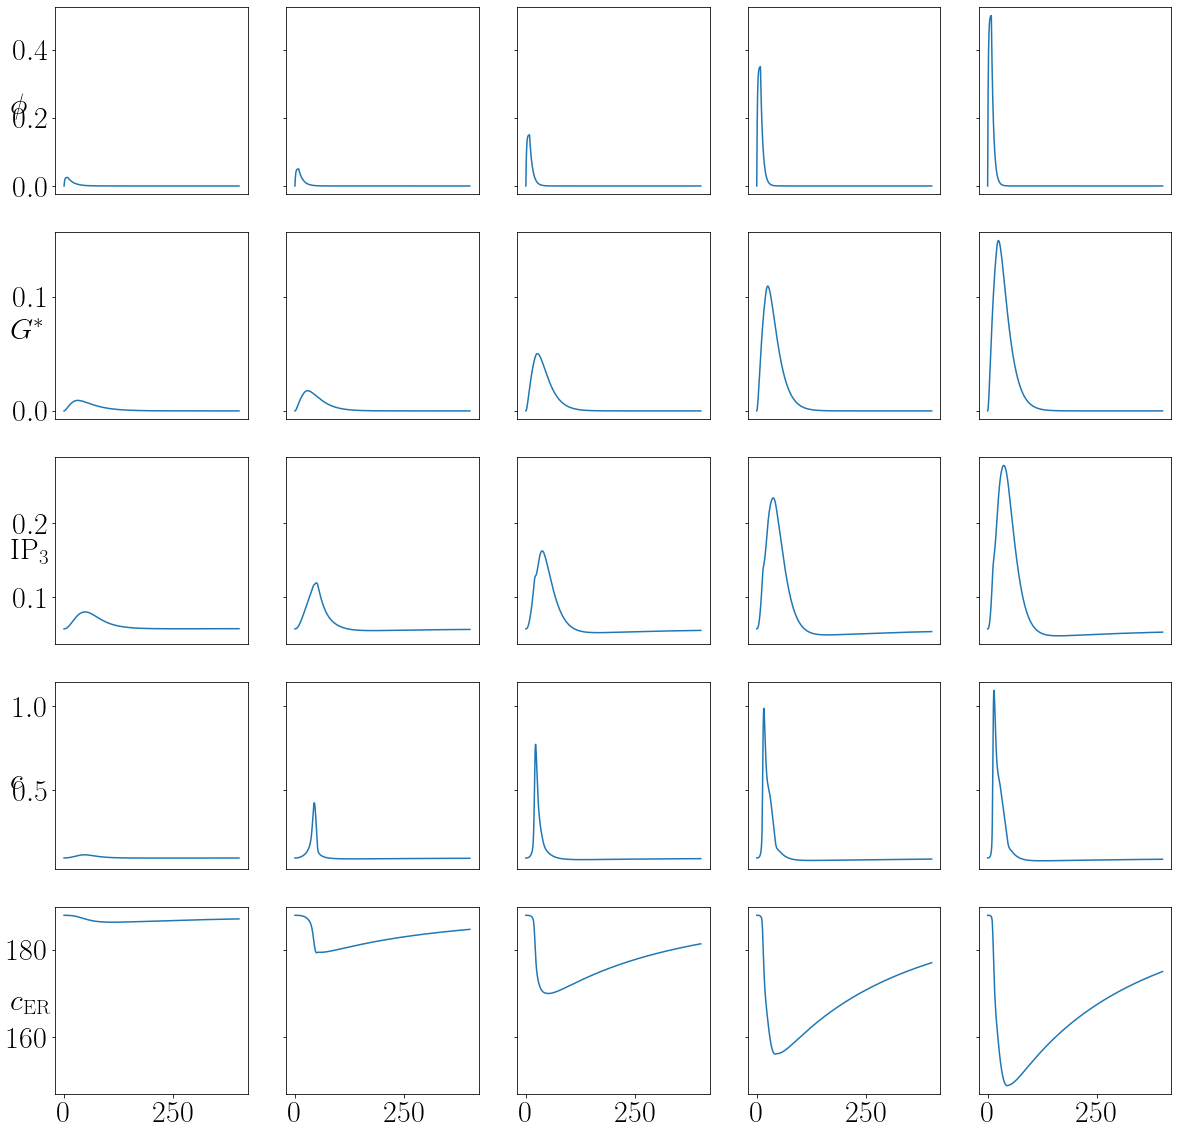

In [25]:
fig, ax = plt.subplots(5, 5, figsize=(20,20), sharey='row')
r_rise = 0.3
# d_decay = 200
d_decay = 56
d_rise = 21
# d_rise = 41
for i, A in enumerate(5*np.array([0.005, 0.01, 0.03, 0.07, 0.1])):
# for i, A in enumerate([0.005, 0.01]):
    remove_yticks = True if i > 0 else False
    r_decay = compute_r_decay(A, d_decay)
#     print(remove_yticks)
    sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'c', 'c_er'], ax[:, i], remove_xticks=True,
                     add_ylabels=not remove_yticks, add_xlabel=False)

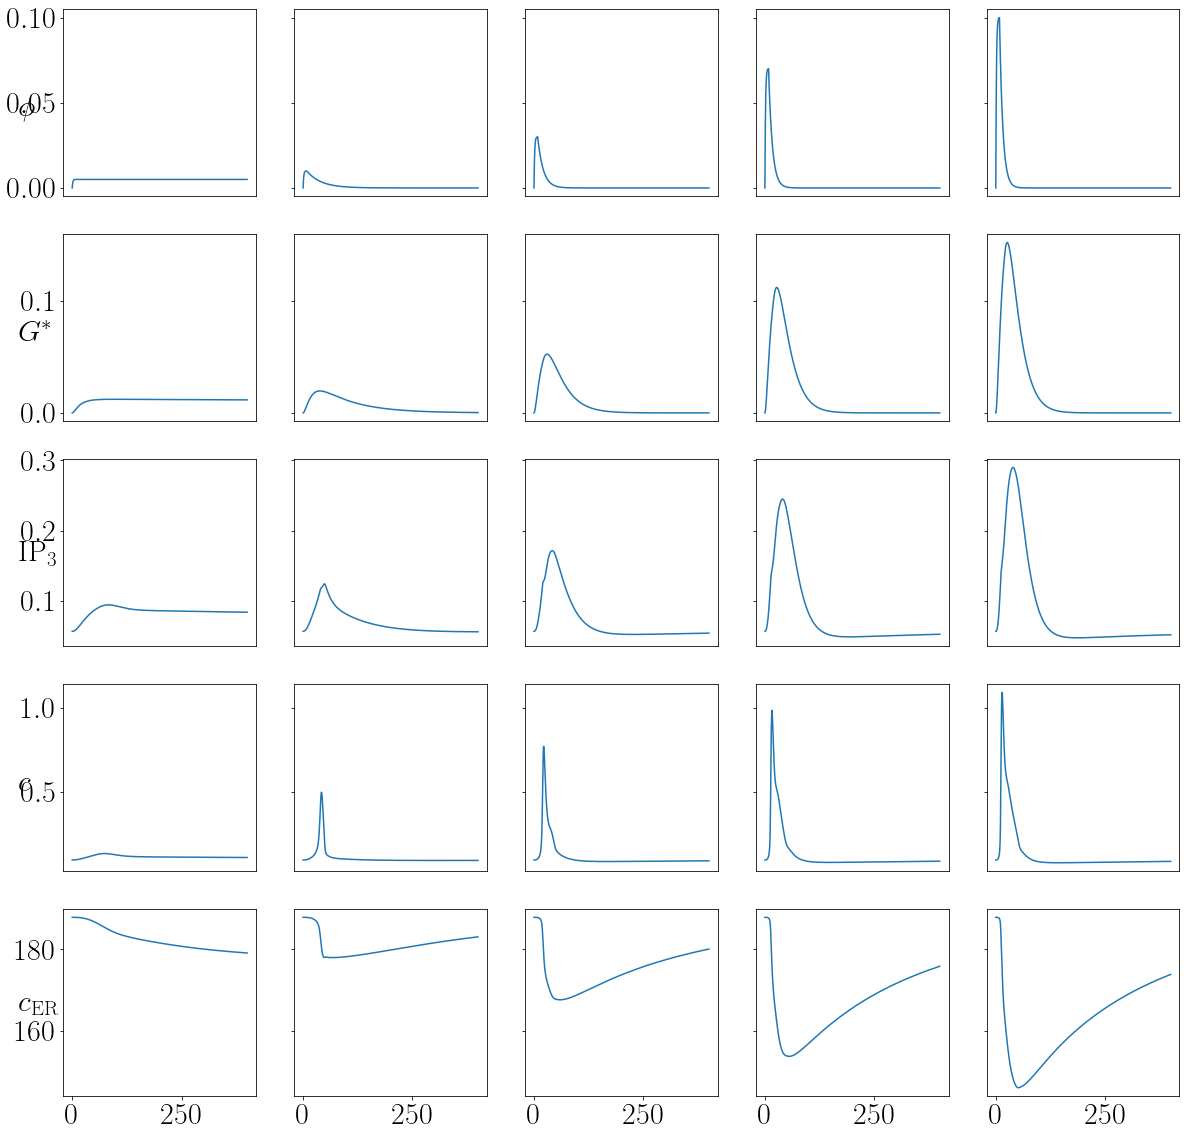

In [26]:
fig, ax = plt.subplots(5, 5, figsize=(20,20), sharey='row')
r_rise = 0.3
# d_decay = 200
d_decay = 56
d_rise = 21
# d_rise = 41
cfg.kp = 0.15
for i, A in enumerate(np.array([0.005, 0.01, 0.03, 0.07, 0.1])):
# for i, A in enumerate([0.005, 0.01]):
    remove_yticks = True if i > 0 else False
    r_decay = compute_r_decay(A, d_decay)
#     print(remove_yticks)
    sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'c', 'c_er'], ax[:, i], remove_xticks=True,
                     add_ylabels=not remove_yticks, add_xlabel=False)
cfg.kp = 0.03

In [4]:
%%time

cfg.v_beta = 0.6

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)

cfg.v_beta = 0.2

results.to_pickle('data/glut_classification_v_beta_0.2')

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 3min 13s


In [5]:
results.to_pickle('data/glut_classification_v_beta_0.2')

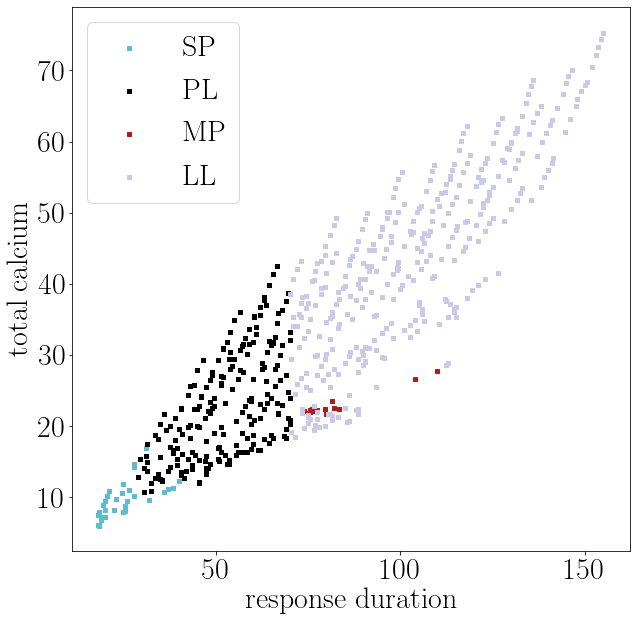

In [6]:
results = pd.read_pickle('data/glut_classification_v_beta_0.2')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
plt.savefig('figures/ca_classification/glut_classification_v_beta_0.2.png')

# Testing with positive negative feedback off

## Positive Feedback Off

In [6]:
%%time

cfg.v_3k = 0
cfg.v_delta = 0
all_init = cfg.all_init
cfg.all_init = cfg.all_init_no_pos_no_neg

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)

cfg.v_delta = 0.01
cfg.v_3k = 0.1
cfg.all_init = all_init

results.to_pickle('data/glut_classification_no_pos_no_neg')

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 5min 43s


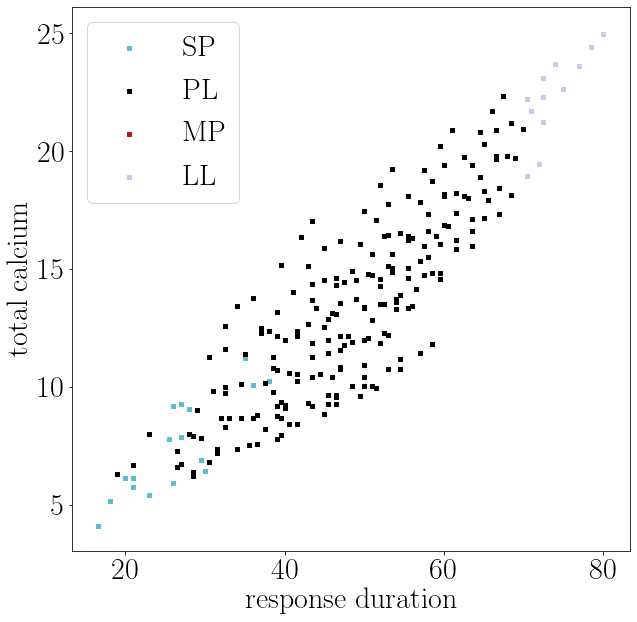

In [9]:
results = pd.read_pickle('data/glut_classification_no_pos')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
# plt.savefig('figures/ca_classification/glut_classification_v_beta_0.2.png')

## Negative Feedback Off

In [7]:
%%time

# cfg.v_3k = 0
cfg.v_delta = 0
all_init = cfg.all_init
cfg.all_init = cfg.all_init_no_pos

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)

cfg.v_delta = 0.01
cfg.v_3k = 0.1
cfg.all_init = all_init

results.to_pickle('data/glut_classification_no_pos')

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 5min 32s


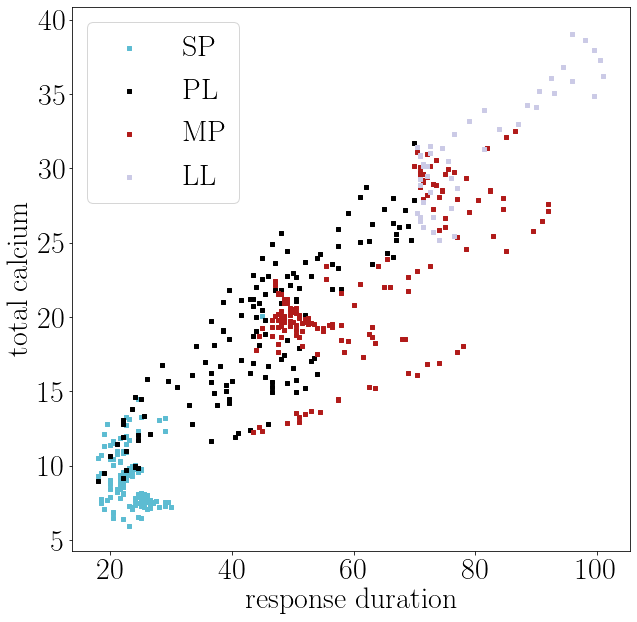

In [10]:
results = pd.read_pickle('data/glut_classification_no_neg')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
# plt.savefig('figures/ca_classification/glut_classification_v_beta_0.2.png')

## Positive and Negative Feedback Off

In [8]:
%%time

cfg.v_3k = 0
# cfg.v_delta = 0
all_init = cfg.all_init
cfg.all_init = cfg.all_init_no_neg

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)

cfg.v_delta = 0.01
cfg.v_3k = 0.1
cfg.all_init = all_init

results.to_pickle('data/glut_classification_no_neg')

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 5min 32s


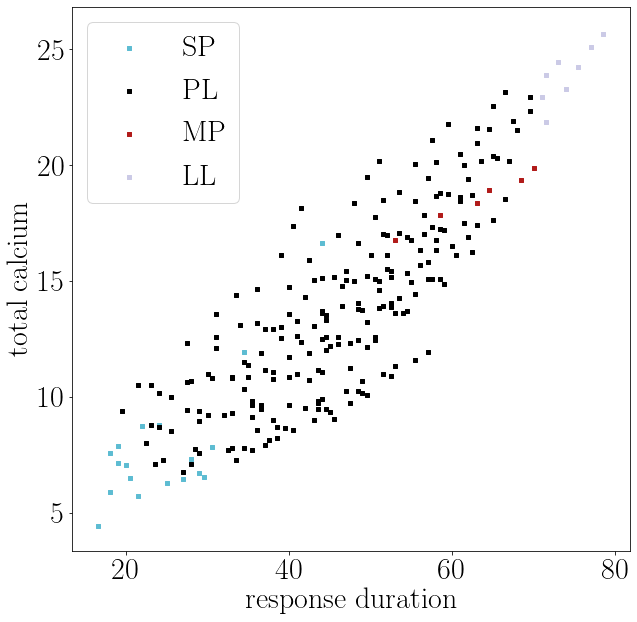

In [11]:
results = pd.read_pickle('data/glut_classification_no_pos_no_neg')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
# plt.savefig('figures/ca_classification/glut_classification_v_beta_0.2.png')

## Negative Feedback Tuned Down (k_d = 1.5)

In [4]:
%%time

# cfg.v_3k = 0
# cfg.v_delta = 0
cfg.k_d = 1.5
all_init = cfg.all_init
# cfg.all_init = cfg.all_init_no_pos

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)

# cfg.v_delta = 0.01
# cfg.v_3k = 0.1
cfg.k_d = 0.7
cfg.all_init = all_init

results.to_pickle('data/glut_classification_neg_down')

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 3min 49s


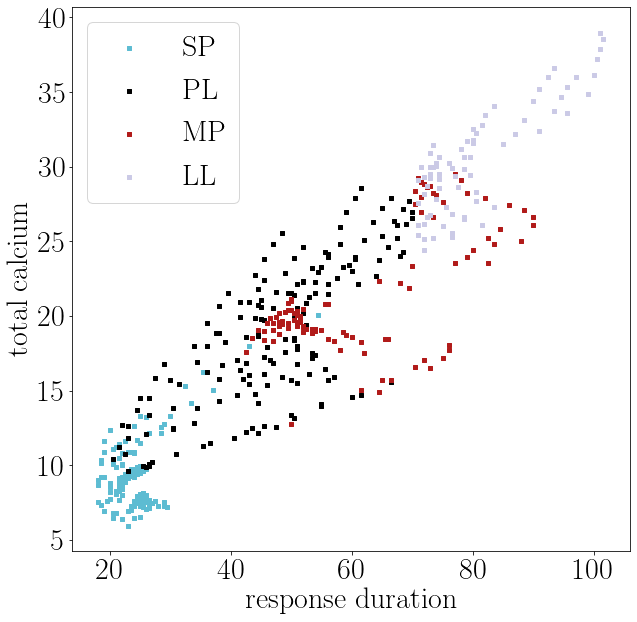

In [5]:
results = pd.read_pickle('data/glut_classification_neg_down')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
# plt.savefig('figures/ca_classification/glut_classification_v_beta_0.2.png')

## Negative Feedback Tuned Down (k_d = 0.9)

In [7]:
%%time

# cfg.v_3k = 0
# cfg.v_delta = 0
cfg.k_d = 0.9
all_init = cfg.all_init
# cfg.all_init = cfg.all_init_no_pos

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)

# cfg.v_delta = 0.01
# cfg.v_3k = 0.1
cfg.k_d = 0.7
cfg.all_init = all_init

results.to_pickle('data/glut_classification_neg_down_0.9')

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 3min 18s


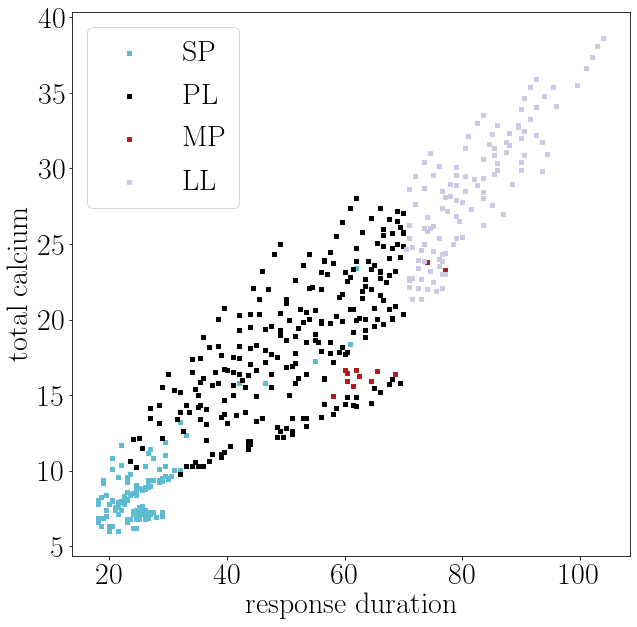

In [8]:
results = pd.read_pickle('data/glut_classification_neg_down_0.9')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
# plt.savefig('figures/ca_classification/glut_classification_v_beta_0.2.png')

## Negative Feedback Tuned Down (k_d = 1)

In [9]:
%%time

# cfg.v_3k = 0
# cfg.v_delta = 0
cfg.k_d = 1
all_init = cfg.all_init
# cfg.all_init = cfg.all_init_no_pos

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)

# cfg.v_delta = 0.01
# cfg.v_3k = 0.1
cfg.k_d = 0.7
cfg.all_init = all_init

results.to_pickle('data/glut_classification_neg_down_1')

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 3min 22s


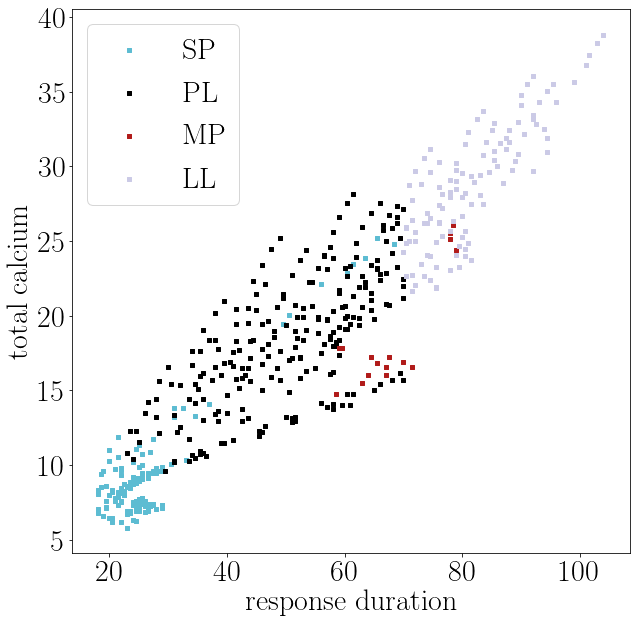

In [10]:
results = pd.read_pickle('data/glut_classification_neg_down_1')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
# plt.savefig('figures/ca_classification/glut_classification_v_beta_0.2.png')

## Negative Feedback Tuned Down (k_d = 1.2)

In [11]:
%%time

# cfg.v_3k = 0
# cfg.v_delta = 0
cfg.k_d = 1.2
all_init = cfg.all_init
# cfg.all_init = cfg.all_init_no_pos

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)

# cfg.v_delta = 0.01
# cfg.v_3k = 0.1
cfg.k_d = 0.7
cfg.all_init = all_init

results.to_pickle('data/glut_classification_neg_down_1.2')

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 3min 28s


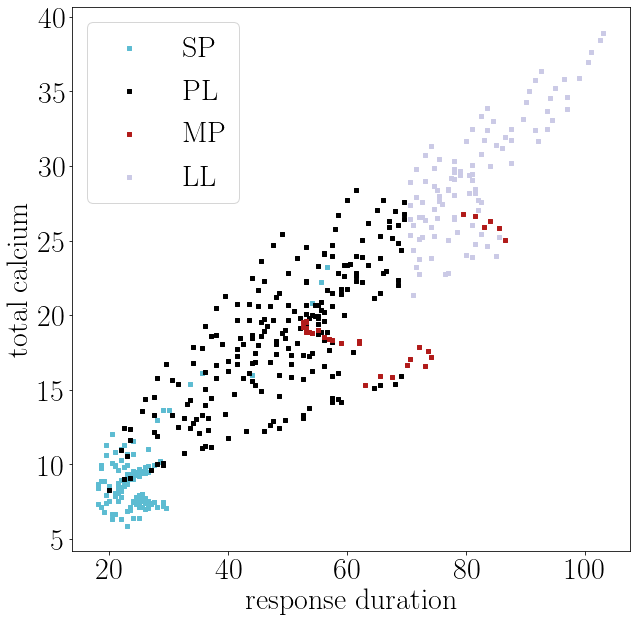

In [12]:
results = pd.read_pickle('data/glut_classification_neg_down_1.2')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
# plt.savefig('figures/ca_classification/glut_classification_v_beta_0.2.png')

## Negative Feedback Tuned Down (k_d = 1.1)

In [13]:
%%time

# cfg.v_3k = 0
# cfg.v_delta = 0
cfg.k_d = 1.1
all_init = cfg.all_init
# cfg.all_init = cfg.all_init_no_pos

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)

# cfg.v_delta = 0.01
# cfg.v_3k = 0.1
cfg.k_d = 0.7
cfg.all_init = all_init

results.to_pickle('data/glut_classification_neg_down_1.1')

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 3min 30s


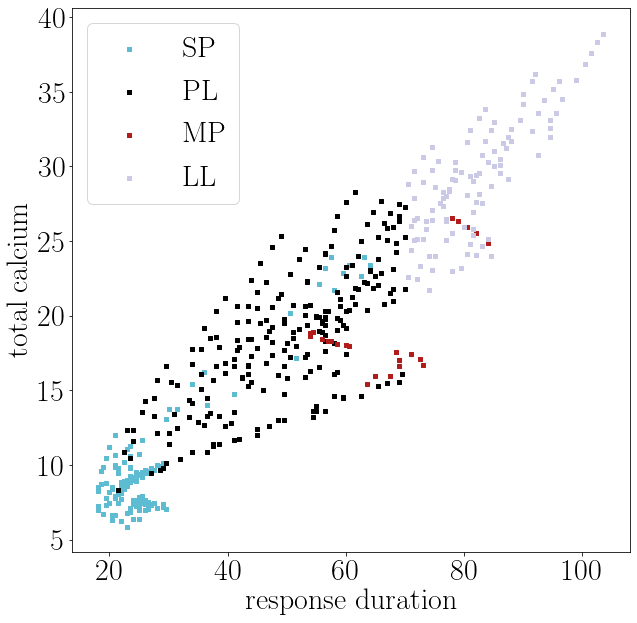

In [14]:
results = pd.read_pickle('data/glut_classification_neg_down_1.1')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
# plt.savefig('figures/ca_classification/glut_classification_v_beta_0.2.png')

# c_tot initial changed

In [4]:
%%time

# cfg.v_3k = 0
# cfg.v_delta = 0
# cfg.k_d = 1.2
all_init = cfg.all_init
# cfg.all_init = cfg.all_init_no_pos
cfg.all_init[1] = all_init[1] * 0.8

A_range = [0.05, 0.1, 0.2, 0.3, 0.4]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                
                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=400, max_step=0.5)
                t = sol.t
                c = sol.y[0]
                
                response_type = calcium_response_classification(t, c)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)

# cfg.v_delta = 0.01
# cfg.v_3k = 0.1
cfg.k_d = 0.7
cfg.all_init = all_init

results.to_pickle('data/glut_classification_ct_0.8')

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Wall time: 3min 8s


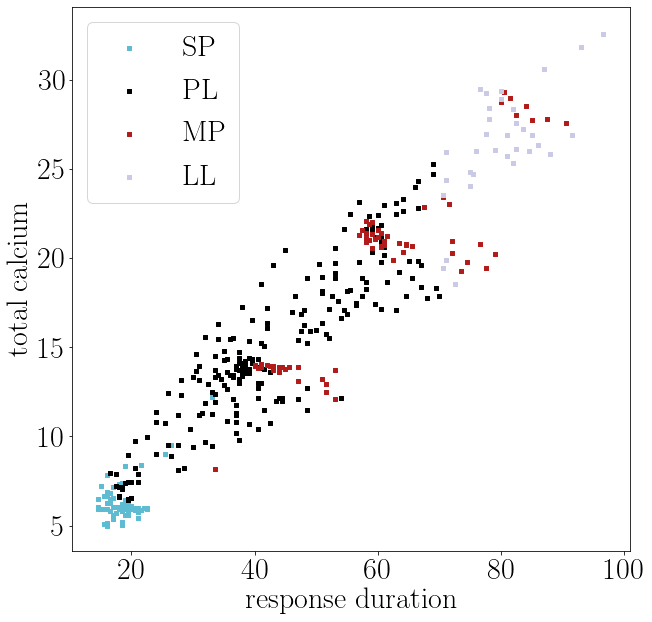

In [5]:
results = pd.read_pickle('data/glut_classification_ct_0.8')
plt.figure(figsize=(10,10))

#add colors to results
colors = {
    'SP': '#5dbcd2', #blue
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

for response_type in colors.keys():
    responses = results[results['response_type'] == response_type]
    plt.scatter(responses['response_duration'], responses['c_total'], color=colors[response_type], 
               label=response_type, marker='s', s=20)
    
plt.xlabel('response duration')
plt.ylabel('total calcium')
plt.legend()
# plt.savefig('figures/ca_classification/glut_classification_v_beta_0.2.png')